# Learning objective

This notebook demonstrates the Zabusky &amp; Kruskal numerical experiment, and the emergence of solitons from a harmonic initial condition for the KdV equation.

# Preliminaries

In [1]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25,
          'animation.embed_limit': 2**128}
plt.rcParams.update(params)
%matplotlib inline
from matplotlib import colormaps
from mpl_toolkits.mplot3d import axes3d

# for animations
from matplotlib import animation, rc
from IPython.display import HTML

# numerics
import numpy as np
from scipy.integrate import solve_ivp
from scipy import fft
from scipy.interpolate import griddata

# to save plots as files and download them
from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

Code adapted from footnotes in the [landmark](https://physics.aps.org/articles/v6/15) paper by Zabusky and Kruskal in [_Physical Review Letters_](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.15.240).

Notes (extra):
*   http://www.scholarpedia.org/article/Soliton (The code provided therein, based on Ch. 10 of [Trefethen's book](https://epubs-siam-org.ezproxy.lib.purdue.edu/doi/book/10.1137/1.9780898719598) is more efficient, but I did not implement it here; see also Ch. 7 in [J. Yang's book](https://epubs-siam-org.ezproxy.lib.purdue.edu/doi/book/10.1137/1.9780898719680) for more on numerical methods for nonlinear waves, and [this neat code](https://scipy-cookbook.readthedocs.io/items/KdV.html) using pseudospectral discretization in space and, then, the method of lines, as below.)

# The KdV equation

Zabusky and Kruskal consider
$$ u_t + uu_x + \delta^2 u_{xxx} = 0 $$
subject to periodic boundary conditions (BCs):
$$ u(0,t) = u(2,t). $$
They restrict themselves to the spatial interval $0\le x \le 2$ and consider only $\delta = 0.022$.

In [2]:
# dispersion parameter from ZK65
delta = 0.022

# spatial interval
xmin = 0
xmax = 2.0

# number of grid points in discretization
N = 250
# grid spacing
h = (xmax-xmin)/N

# the grid
xj = np.linspace(xmin,xmax,num=N,endpoint=False)

## The solitary wave solution

Zabusky and Kruskal [Eqs. (2)--(4) in their paper] also show that the solitary wave solution to KdV, which they go on to term 'soliton' (after establishing its interaction property), takes the form:
$$ u(x,0) = u_\infty + (u_0-u_\infty)\mathrm{sech}^2[(x-x_0)/\Delta], \quad \Delta := \delta/\sqrt{(u_0-u_\infty)/12}. $$
The phase velocity of the solitary wave is $v_0 = u_\infty + (u_0-u_\infty)/3$. The amplitude of the solitary wave is $A=u_0-u_\infty$. $\Delta$ can be interpreted as its typical "width" (~[FWHM](https://mathworld.wolfram.com/FullWidthatHalfMaximum.html)).

For simplicity, take $u_\infty=0$.

In [3]:
# the soliton
def soli(x,t,x0,u0,uinf,delt):
  ddelt = delt/np.sqrt((u0 - uinf)/12)
  v0 = uinf + (u0 - uinf)/3
  # to make the output periodic on [0,xmax]
  x = x + (xmax-xmin)/2
  arg = (x-x0-v0*t)%(xmax-xmin)
  arg = (xmax-xmin)/2 - arg
  u = uinf + (u0 - uinf)*1/np.cosh(arg/ddelt)**2
  return u

In [4]:
def plot_soli(x0,u0,δ):
  ax = plt.gca()
  u = soli(xj,0,x0,u0,0,δ)
  ax.plot(xj, u, color='blue', linewidth=2)
  ax.set_ylabel('$u$')
  #ax.set_ylim(0,1.05*max(u))
  ax.set_xlabel('$x$')
  #ax.set_xlim(-1,1)
  plt.show()

interact(plot_soli, x0 = widgets.FloatSlider(value=1, min=-1, max=3, step=0.1),
                    u0 = widgets.FloatSlider(value=4, min=0, max=10, step=0.5),
                    δ = widgets.FloatSlider(value=0.05, min=0.001, max=0.15, step=0.001) );

interactive(children=(FloatSlider(value=1.0, description='x0', max=3.0, min=-1.0), FloatSlider(value=4.0, desc…

## The initial condition

Zabusky and Kruskal used a harmonic initial condition (IC):
$$ u(x,0) = \cos(\pi x). $$

In [5]:
# orignal ZK65
ic_type = 'ZK65'
uic = np.cos(np.pi*xj)

Another interesting IC is created by superimposing two of solitary waves (by picking two $u_0$ values and two $x_0$ values, such that the pulses are initially well-spaced out). A linear superposition is _not_ an exact solution to KdV but, because $\mathrm{sech} \equiv 1/\cosh$ goes to 0 exponentially fast for large arguments, we _might_ expect a well-spaced-out summation of two pulses to be a good approximation.

In [6]:
# linear superposition of two solitons
ic_type = 'twosoli'
# define the superposition via a function for all t
def twosoli(x,t):
  return soli(x,t,0.5,2,0,delta) + soli(x,t,1.5,1,0,delta)
# evaluate at t = 0 for the initial conditon
uic = twosoli(xj,0)

In [7]:
soli(0.5,0,0.5,2,0,delta)

2.0

In [8]:
soli(1.5,0,1.5,1,0,delta)

1.0

Whichever initial condition we chose, let's plot it.

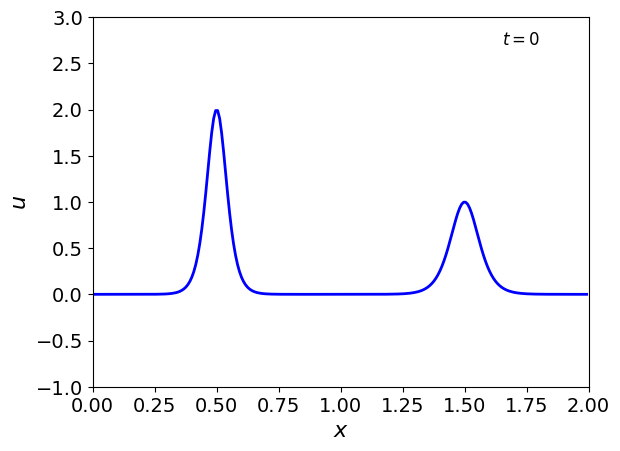

In [9]:
fig, ax = plt.subplots()
ax.plot(xj, uic, color='blue', linewidth=2)
# set common ylims for all plots below, so it they don't get scaled dynamically
ax.set_ylim(-1,3)
ax.set_ylabel('$u$')
ax.set_xlim(0,xmax)
ax.set_xlabel('$x$')
ax.text(0.825, 0.925, f'$t=0$', size='large', transform=ax.transAxes);

# Numerical solution

In footnote 6, Zabusky and Kruskal provide their space-time discretization of the KdV partial differential equation. Below, I implement the same spatial discretization, but leave the problem _semi-discrete_ and use [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) from SciPy to advance the solution in time. This change makes the code consistent with our earlier exploration of the FPUT chain.

So, the semi-discrete problem (this approach is called the [method of lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html)) we wish to solve is
$$ \dot{u}_j = -\underbrace{\left(\frac{u_{j+1} + u_j + u_{j-1}}{3}\right)}_{\approx u}\underbrace{\left(\frac{u_{j+1} - u_{j-1}}{2h}\right)}_{\approx u_x} - \delta^2\underbrace{\left(\frac{u_{j+2} - 2u_{j+1} + 2u_{j-1} - u_{j-2}}{2h^3}\right)}_{\approx u_{xxx}},\quad j=0,\dots,N-1 $$
so that $u_j(t) \approx u(x_j,t)$, where $x_j = 0+jh$ with $h=(x_\mathrm{max}-0)/N$ being the grid spacing.

Here, $j=N$ is not included because, by periodic BCs, $u_0=u_{N}$ are the _same_ gridpoint.

In [10]:
# ODE system right-hand side
def zk65(t,u):
  F = np.empty(N)

  # boundary nodes require special care to enforce perdiodic BCs
  F[0] = -(u[1] + u[0] + u[N-1])/3 * (u[1] - u[N-1])/(2*h) \
         -delta**2*(u[2] - 2*u[1] + 2*u[N-1] - u[N-2])/(2*h**3)
  F[1] = -(u[2] + u[1] + u[0])/3 * (u[2] - u[0])/(2*h) \
         -delta**2*(u[3] - 2*u[2] + 2*u[0] - u[N-1])/(2*h**3)
  F[N-2] = -(u[N-1] + u[N-2] + u[N-3])/3 * (u[N-1] - u[N-3])/(2*h) \
             -delta**2*(u[0] - 2*u[N-1] + 2*u[N-3] - u[N-4])/(2*h**3)
  F[N-1] = -(u[0] + u[N-1] + u[N-2])/3 * (u[0] - u[N-2])/(2*h) \
             -delta**2*(u[1] - 2*u[0] + 2*u[N-2] - u[N-3])/(2*h**3)

  # interior nodes, per the formula
  for j in range(2,N-2):
    F[j] = -(u[j+1] + u[j] + u[j-1])/3 * (u[j+1] - u[j-1])/(2*h) \
           -delta**2*(u[j+2] - 2*u[j+1] + 2*u[j-1] - u[j-2])/(2*h**3)

  return F

In [11]:
# simulation parameters
# maximum integration time is 35*T_B, T_B=1/pi (see ZK65)
# in order to try to see the 'recurrence' at 30.4*T_B
TB = 1/np.pi
tmax = 35*TB

# try: test different tolerances for the integrator, changing reltol
reltol = 1e-4

We use SciPy's [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to numerically integrate the system of $N$ ODEs forward in time using the '[Radau](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Radau_methods)' method for [stiff](https://en.wikipedia.org/wiki/Stiff_equation) problems, with time-step adaptation and error control. (Try also 'LSODA' if you want. 'RK45' is not very-well-behaved for this problem with long integration times `tmax`; numerical oscillations show up...)

In [12]:
# solve the semi-discrete KdV
sol = solve_ivp(fun=zk65,
                t_span=[0,tmax], y0=uic,
                method='Radau', rtol=reltol, dense_output=True)

# Plotting and dynamics

## Static plot

First, just a quick static plot of the solution at the final time.

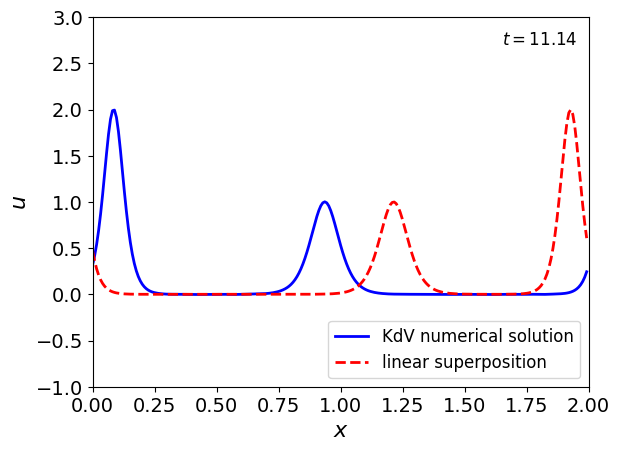

In [13]:
tplot = 35*TB #3.6*TB
uj = sol.sol(tplot)

fig, ax = plt.subplots()

ax.plot(xj, uj, linewidth=2, color='blue', label='KdV numerical solution')
if ic_type == 'twosoli':
  ax.plot(xj, twosoli(xj,tplot), linewidth=2, color='red',
          linestyle='dashed', label='linear superposition')
  ax.legend(loc='lower right')

ax.set_ylabel('$u$')
ax.set_ylim(-1,3)
#ax.set_ylim(-0.02,0.02) # use this range to check of 'wiggly' tails
ax.set_xlabel('$x$')
ax.set_xlim(0,xmax)
ax.text(0.825, 0.925, f'$t={tplot:.2f}$', size='large', transform=ax.transAxes);

**Comments**:
*   For the ZK65 cosine initial condition, why do we observe 8 peaks in this plot? Is that 8 'solitons'? [I made a contribution](http://arxiv.org/abs/0910.3345) to this topic years ago. Later, [others](https://www-sciencedirect-com.ezproxy.lib.purdue.edu/science/article/pii/S0167278916000452) got a more precise answer using advanced techniques.
*   For the two-soliton initial condition, we observe a 'phase shift' of the KdV solution with respect to just evaluating the linear two-soliton superposition at the plotting time (by 'phase shift', we mean that the peaks are offset between the two curves).

## Animation

Next, we visualize our results using our snazzy animation tools.

In [14]:
# define how to sample the solution in time
tnum = N
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [15]:
# set up the figure and axes
fig, ax = plt.subplots()
ax.set_ylabel('$u$')
ax.set_xlabel('$x$')
ax.set_xlim(0,xmax)
ax.set_ylim(-1,3)
# nice dynamic label to show time
ttl = ax.text(0.825, 0.925, '', size='large',
              #bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'),
              transform=ax.transAxes, animated=True)
# so axes labels aren't cut off
plt.tight_layout()
plt.close()

# initialize plot objects with some dummy data (replaced in animation)
line, = ax.plot(xj, 0*xj, color='blue', linewidth=2)

# animation function called sequentially by `FuncAnimation' below
def animate(it):
  uj = sol.sol(it*dt)
  line.set_data(xj, uj)
  ttl.set_text(f'$t={it*dt:.2f}$')

  return (line, ttl, )

framran = range(0,tnum)
anim = animation.FuncAnimation(fig, animate, frames=framran,
                               interval=100, blit=True)

# this is necessary to get the animation to work on Google's Colab
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

# Further explorations

## Conservation properties of the solution

Zabusky and Kruskal claim that, in their scheme, the "momentum"
$$ \sum_{j=0}^{N-1} u_j (t) $$
is exactly conserved, and the "energy"
$$ \sum_{j=0}^{N-1} \frac{1}{2}[u_j (t)]^2 $$
is _almost_ conserved. (Again, $j=N$ is not included because it is the same gridpoint as $j=0$ for periodic BCs.)
Note that these quantities are kind of like midpoint rule approximations to $ \frac{1}{x_\mathrm{max}}\int_0^{x_\mathrm{max}} u(x,t) \,dx$ and $\frac{1}{x_\mathrm{max}}\int_0^{x_\mathrm{max}} \tfrac{1}{2}[u(x,t)]^2 \,dx$.

Let us check these conservation properties for our numerical solution/scheme.

Verifying whether conservation properties of the continuous PDE are reflecte in the discrete solution will give us confidence in our numerical methods/solutions.

In [16]:
# define how to sample the solution in time
tnum = N
dt = (tmax-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

In [17]:
# compute the momentum and energy as functions of t
momentum = np.empty(tnum)
energy = np.empty(tnum)
for it in range(0,tnum):
  uj = sol.sol(it*dt)
  momentum[it] = np.sum(uj)
  energy[it] = np.sum(0.5*uj**2)

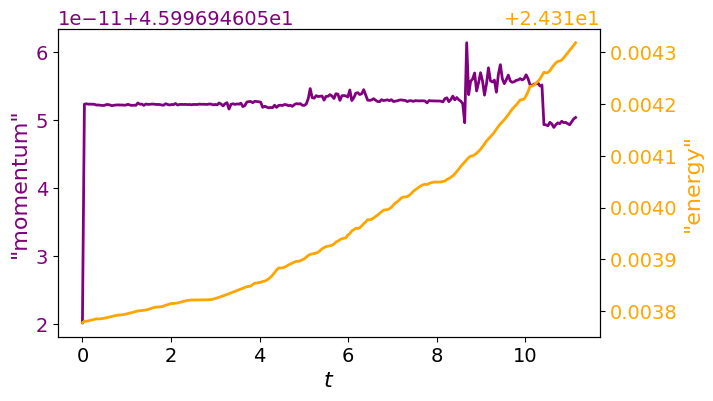

In [18]:
fig, ax1 = plt.subplots(figsize=(7,4))

# momentum on the left axis
ax1.plot(tspan, momentum, lw=2, color='purple')
ax1.set_ylabel('"momentum"', color='purple')
ax1.set_xlabel('$t$')
ax1.tick_params(axis='y', labelcolor='purple')

# energy on the right axis
ax2 = ax1.twinx()
ax2.plot(tspan, energy, color='orange', lw=2)
ax2.set_ylabel('"energy"', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

## Recurrence

Just like the FPUT problem, the ZK problem for KdV is said (conjectured?) to exhibit a recurrence. It was calculated to occur at $t=T_R=30.4T_b=30.4/\pi$ by Zabusky and Kruskal. Let's check it.

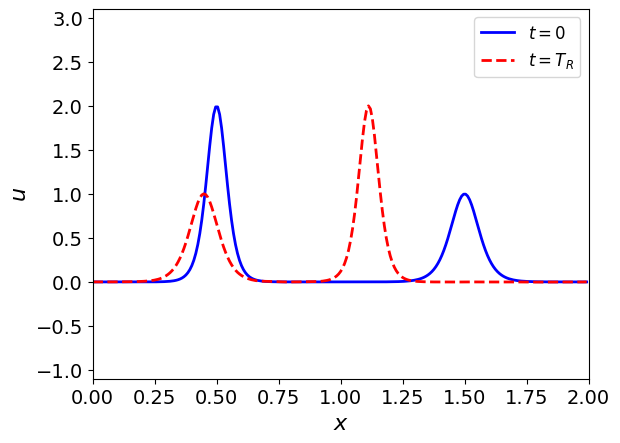

In [19]:
fig, ax = plt.subplots()
# plot IC (t=0)
ax.plot(xj, uic, color='blue', lw=2, label='$t=0$')
# plot solution at t=T_R to check recurrrence
trecur = 30.4*TB
uj = sol.sol(trecur)
ax.plot(xj, uj, color='red', lw=2, ls='--', label='$t=T_R$')

ax.set_ylim(-1.1,3.1)
ax.set_ylabel('$u$')
ax.set_xlim(0,xmax)
ax.set_xlabel('$x$')
ax.legend(loc='best');

Even if we ignore the half-period shift, this it is **not** a very satisfying recurrence! Actually...[others](https://aip-scitation-org.ezproxy.lib.purdue.edu/doi/pdf/10.1063/1.862824) noticed this too (~15 years after ZK65). A recent (2015, 60 years later!) book ([the first chapter](http://www.ams.org/books/conm/635/)) attempts to explain this matter; it's not so simple it turns out.

## Space-time view of the dynamics

Let's also try to recreate the space-time view of the 'soliton fission' from the harmonic initial condition, as in ZK65, or its [colorful](http://www.scholarpedia.org/article/File:Fig3_soliton.jpeg) variations.

For ZK65, it is most logical to choose a [diverging](https://matplotlib.org/stable/users/explain/colors/colormaps.html#diverging) colormap, like `RdGy` or `coolwarm` because $u$ is _both_ positive and negative in the simulation. For single or multiple soliton initial conditions, when $u>0$ for all $t$, it might make more sense to use a [sequential](https://matplotlib.org/stable/users/explain/colors/colormaps.html#sequential) like `plasma`.

In [32]:
# define how to sample the solution in time
tnum = N
dt = (trecur-0)/(tnum-1)
tspan = np.array(range(0,tnum))*dt

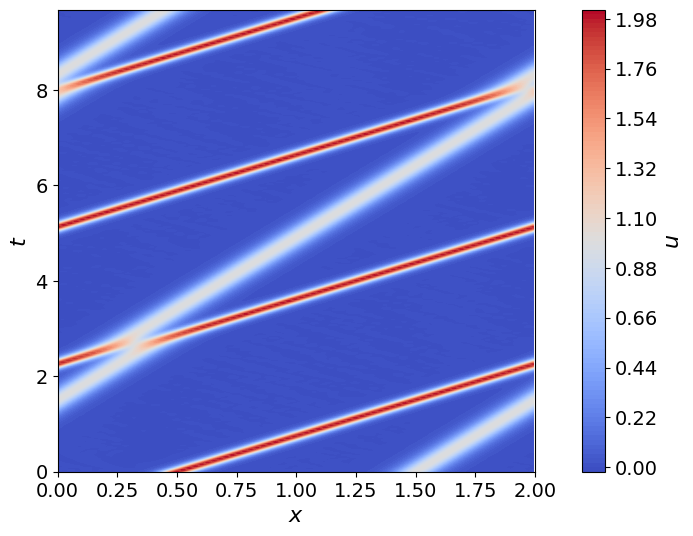

In [33]:
# make a matrix of space-time values u(x,t)
ujp = np.empty((tnum,N))
for it in range(0,tnum):
  ujp[it,:] = sol.sol(it*dt)

# make cool plot
fig, ax = plt.subplots(figsize=(12, 6))
plt.contourf(xj, tspan, ujp, 100, cmap='coolwarm')
plt.colorbar(label='$u$')
ax.set_ylim(0,tspan[-1])
ax.set_ylabel('$t$')
ax.set_xlim(0,xmax)
ax.set_xlabel('$x$')
ax.set_aspect(1/5)

# Ideas to explore on your own

A few ideas for interesting "computational experiments" to explore on your own are outlined here.

1.   Study how a taller soliton overtakes a shorter soliton. Specifically, by comparing to the steady propagation of 2 individiual non-interacting solitons, attempt to determine whether a "phase shift" arises from the collision. That is, does the taller one "bump back" the shorter one after overtaking?
2.   Perform a mesh refinement study (larger `N`) and try lower values of `tol` to eliminate small amplitude "wiggles" caused by the numerical discretization (might have to zoom in x100 to see them).
3.   Try different boundary conditions, such a fixed end that causes reflection of the wave at the boundary.
4.   Implement the _exact_ [two-soliton solution](https://eqworld.ipmnet.ru/en/solutions/npde/npde5101.pdf) and compare it to your numerical solution.
5.   Vary the dispersion parameter $\delta$ to see if the number of solitons that emerge from the $\cos(\pi x)$ initial condition changes.
6.  Explore the energetics (by decomposing $u(x,t)$ into Fourier modes with an FFT, like we did for FPUT) of the soliton generation or collision processes, see also [this discussion](https://aip-scitation-org.ezproxy.lib.purdue.edu/doi/10.1063/1.862824).

